Import libs

In [185]:
!pip  install opencv-python  


In [186]:

import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pylab as plt
import cv2

In [187]:
def show_heatmap(image):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(image, linewidth=0,ax=ax)
    plt.show()

import files

In [188]:
def readFile(fileName):
    with open(fileName) as f:
        content = f.read().strip().split('\n')
    content = list(map(float, content))
    return content
raw_data1 = readFile('raw_data3.csv')
print(raw_data1[:10])

[2.2382145725888916, 0.19957392145982555, 0.1061709228239851, 2.2536642574947297, 0.12418121946788986, 0.8767454069387093, 1.6908377866712583, -2.8280402415543873, 0.63392379070094, 0.18793113649219317]


In [189]:
no_of_samples = 18000
raw_sampling_rate =1080 *10**3
rpm = 12
beam_width =2
prf = 1800
sigma = 1
no_of_range_slots = 30



In [190]:
slot_time = 1/(prf*no_of_range_slots)
down_sampling_rate =1/slot_time
sampling_rate = int(raw_sampling_rate/down_sampling_rate)
no_of_down_samples = no_of_samples/sampling_rate
no_of_beams = int(no_of_down_samples/no_of_range_slots)
samples_per_beam = no_of_range_slots*sampling_rate
print("number of don samples", no_of_down_samples, "number of beams", no_of_beams)

number of don samples 900.0 number of beams 30


In [191]:
raw_samples_in_beam = []
for i in range(no_of_beams):
    raw_samples_in_beam.append(raw_data1[i*samples_per_beam:(i+1)*samples_per_beam])

print(raw_samples_in_beam[0][:10])


[2.2382145725888916, 0.19957392145982555, 0.1061709228239851, 2.2536642574947297, 0.12418121946788986, 0.8767454069387093, 1.6908377866712583, -2.8280402415543873, 0.63392379070094, 0.18793113649219317]


In [192]:
data_matrix =[]
u_matrix =[]
for i in range(no_of_beams):
    data_raw = []
    u_raw = []
    
    for j in range(0,len(raw_samples_in_beam[i]), sampling_rate):
        data_raw.append(raw_samples_in_beam[i][j])
        l = max(0, j-20)
        r= min(len(raw_samples_in_beam[i]), j+21)
        lg = max(0, j-2)
        rg = min(len(raw_samples_in_beam[i]), j+3)
        u = np.mean(raw_samples_in_beam[i][l:lg] + raw_samples_in_beam[i][rg:r])
        u_raw.append(u)
    data_matrix.append(data_raw)
    u_matrix.append(u_raw)

data_matrix = np.array(data_matrix)
u_matrix = np.array(u_matrix)
    
        

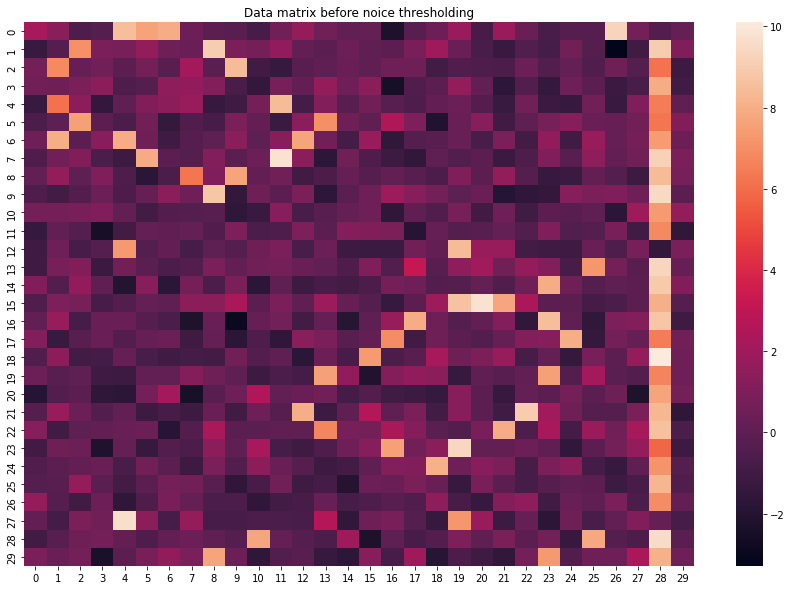

In [193]:

fig, ax = plt.subplots(figsize=(15,10)) 
plt.title("Data matrix before noice thresholding")
ax = sns.heatmap(data_matrix, linewidth=0,ax=ax)
plt.show()

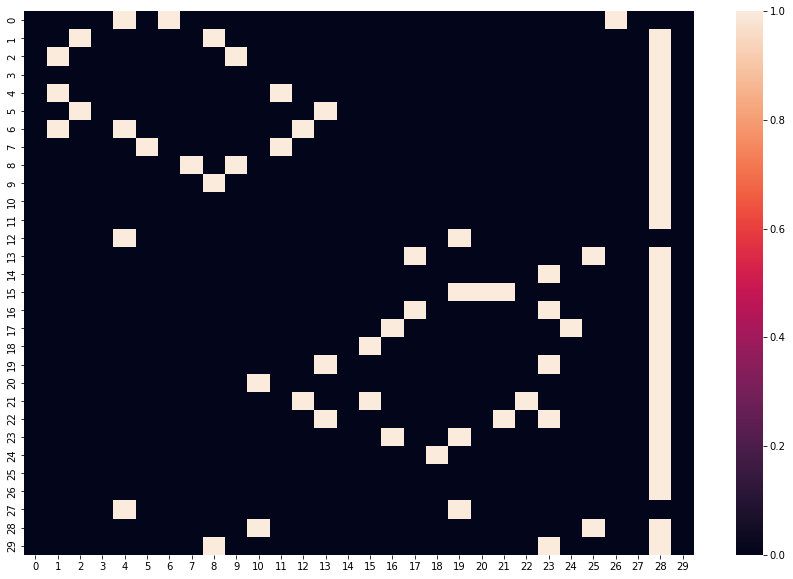

In [194]:
k = 2.5
binary_matrix = np.array([[1.0 if data_matrix[i][j] > u_matrix[i][j]  + k else 0.0 for j in range(len(data_matrix[i]))] for i in range(len(data_matrix))])
show_heatmap(binary_matrix)



In [195]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

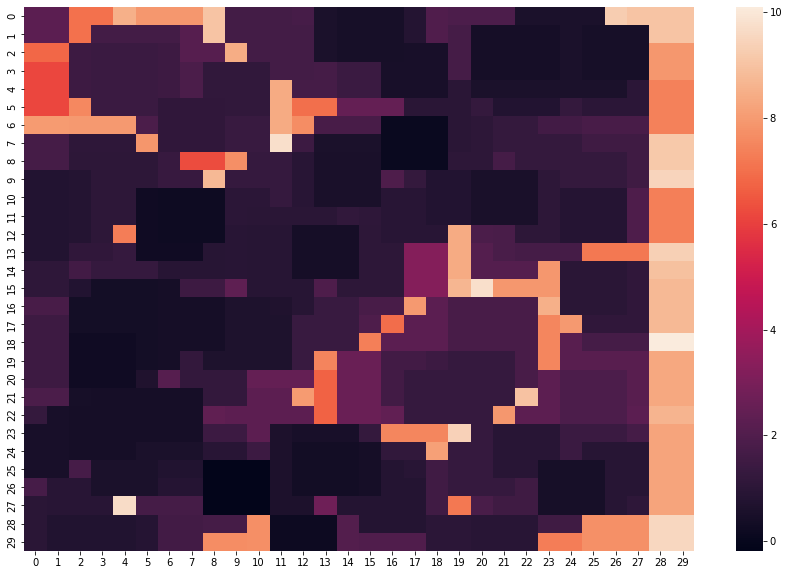

In [196]:
gausian_kernal1 = gkern(l = 3)
gausian_kernal2 = gkern(l = 3)

dst = data_matrix.astype('float32')
for i in range(1):
    dst = cv2.dilate(dst,gausian_kernal1)
    dst = cv2.erode(dst,gausian_kernal2)
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(dst, linewidth=0,ax=ax)
plt.show()

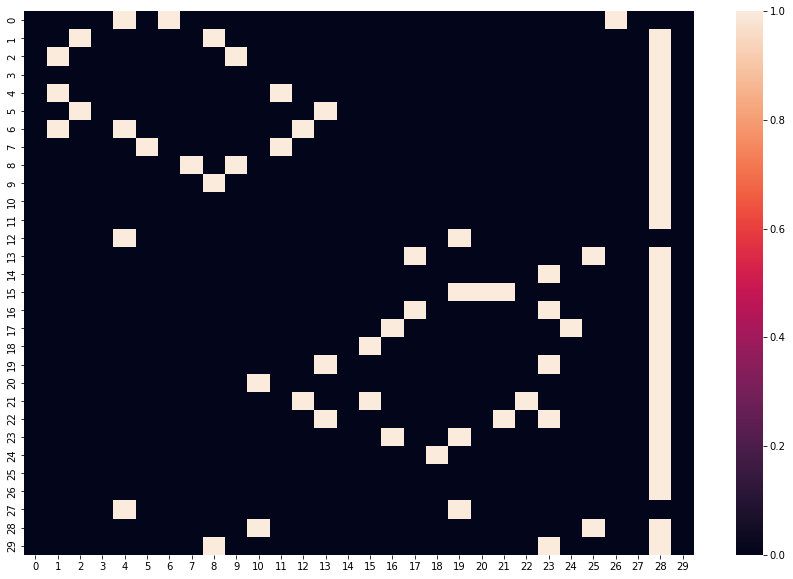

In [197]:
k = 2.5
binary_matrix = np.array([[1.0 if data_matrix[i][j] > u_matrix[i][j]  + k else 0.0 for j in range(len(data_matrix[i]))] for i in range(len(data_matrix))])
show_heatmap(binary_matrix)


In [198]:
#find targets
target_matrix  = np.sum(binary_matrix, axis=0)
target_matrix = target_matrix>15
for i in range(len(binary_matrix)):
    binary_matrix = binary_matrix * (1-target_matrix)


(30, 30)


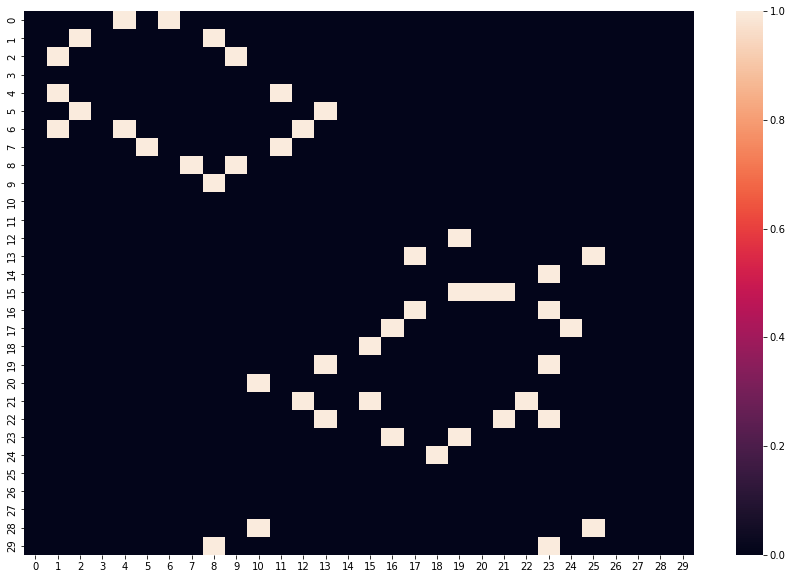

In [199]:
#remove outlires
kernal = np.ones((5,5))

mask  = cv2.filter2D(binary_matrix, -1, kernal, borderType=cv2.BORDER_CONSTANT)
mask_binary = np.array([[1.0 if mask[i][j] > 1 else 0.0 for j in range(len(mask[i]))] for i in range(len(mask))])
masked_binary_matrix = binary_matrix * mask_binary
print(masked_binary_matrix.shape)
show_heatmap(masked_binary_matrix)


In [200]:
#fill max distance == 2 

def fill_two(kernel):
  def filter(kernel):

    for i in range (4):
        if  (kernel[i,0] ==1 and kernel[i,3]==1) : 
          # print('0***')
          kernel[i,1:3] = 4 
        elif (i<3) and (kernel[i,0] ==1 and kernel[i+1,3]==1) :
          # print('*0**')
          kernel[i,1] = 5
          kernel[i+1,2]=5
        elif (i<2) and (kernel[i,0] ==1 and kernel[i+2,3]==1) :
          # print('**0*')
          kernel[i+1,1] = 6
          kernel[i+2,2]=6
        elif (i<1) and (kernel[i,0] ==1 and kernel[i+3,3]==1) :
          # print('***0')
          kernel[i+1,1] = 7
          kernel[i+2,2]=7

    return kernel 


  return filter(kernel)

# fill max distance =1

def fill_ones(kernel):

    if (kernel[0,0] == 1 and kernel[2,2] == 1) or (kernel[0,2] == 1 and kernel[2,0] == 1)  or (kernel[1,0] == 1 and kernel[1,2] == 1) or (kernel[0,1] == 1 and kernel[2,1] == 1): 
      kernel[1,1] = 2

    elif (kernel[0,0] == 1 and (kernel[2,1] == 1 or kernel[1,2] == 1)) and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[0,2] == 1 and (kernel[1,0] == 1 or kernel[2,1] == 1))and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[2,0] == 1 and (kernel[0,1] == 1 or kernel[1,2] == 1))and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[2,2] == 1 and (kernel[1,0] == 1 or kernel[0,1] == 1))and (3 not in kernel): kernel[1,1] = 3   

    return kernel


def draw_lines2 (AAA):
  h,w = AAA.shape
  kernel_offset = 3
  for i in range (0,h-kernel_offset):
    for j in range (0,w- kernel_offset):
      kernel = AAA[i:i+kernel_offset+1,j:j+kernel_offset+1]

      CCC = fill_two(kernel)
      DDD =  np.flip(fill_two(np.flip(CCC,axis=1)),axis=1)
      AAA[i:i+kernel_offset+1,j:j+kernel_offset+1] = np.transpose(fill_two(np.transpose(DDD)))
  return AAA

def draw_lines1 (AAA):
  h,w = AAA.shape
  kernel_offset = 4
  for i in range (0+kernel_offset,h-kernel_offset):
    for j in range (0+kernel_offset,w-kernel_offset):
      kernel = AAA[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1]
      if np.sum(kernel)<5:
        BBB = fill_ones(kernel)
        AAA[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1] = BBB

  return AAA

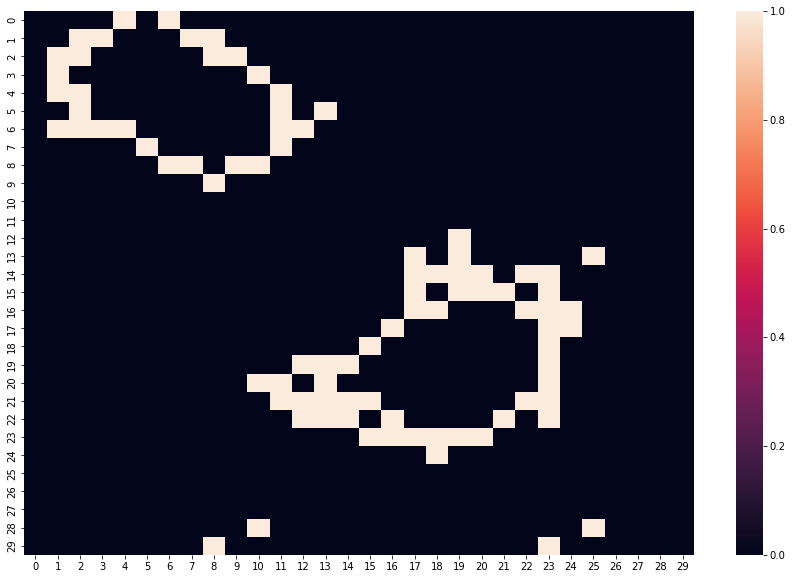

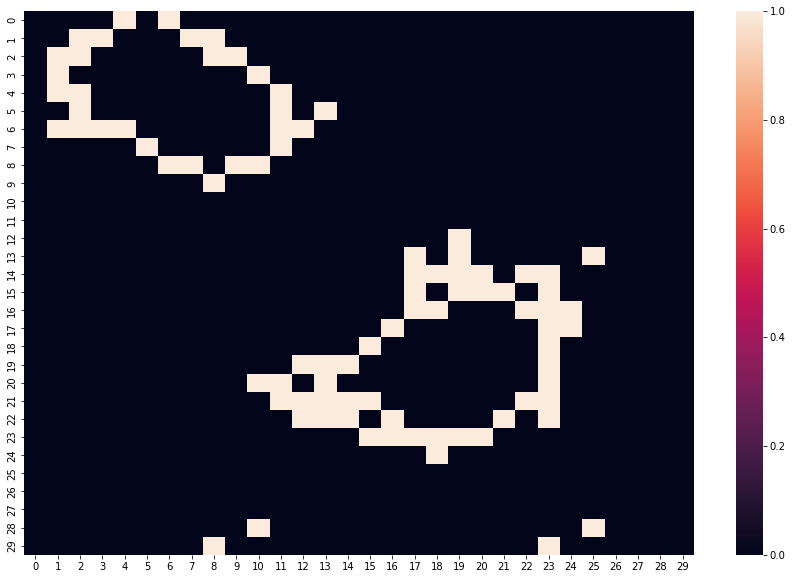

In [201]:
gap2_filled = (draw_lines2(masked_binary_matrix)>0) *1
show_heatmap(gap2_filled)
gap1_filled = (draw_lines1(gap2_filled)>0) 
show_heatmap(gap1_filled)

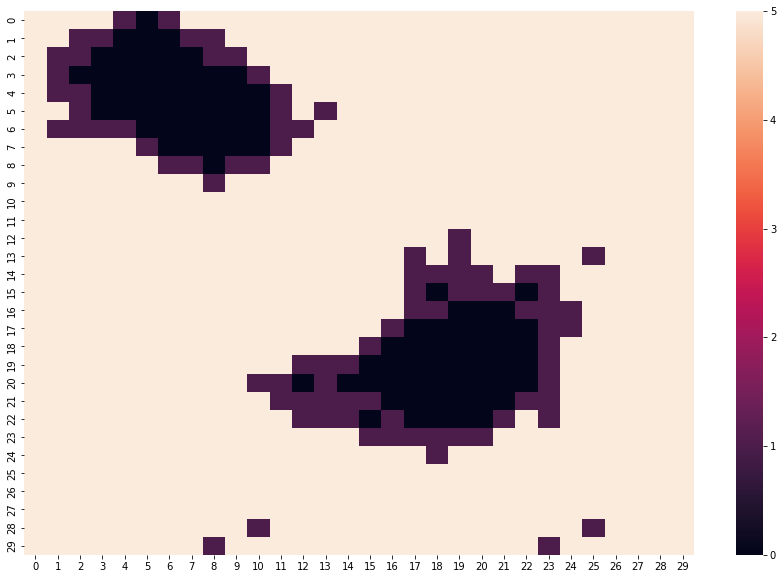

In [202]:
gap1_filled = gap1_filled.astype('uint8')
ff=cv2.floodFill(gap1_filled, None, seedPoint=(0,0), newVal=5)
ff = ff[1].reshape(ff[1].shape[0],ff[1].shape[1])
show_heatmap(ff)